In [2]:
import pandas as pd
import numpy as np
import itertools
import os

from keras import models, layers, regularizers, optimizers, callbacks, utils, losses, metrics
from tensorflow.keras.backend import clear_session
from tensorflow import convert_to_tensor

from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, log_loss

# from tqdm import tqdm
from tqdm.notebook import tqdm

In [2]:
working_dir = '/Volumes/Extreme SSD/rematch_eia_ferc1_docker/working_data/
'model_a/train/x.parquet'
# os.path.join('C:\Users\A\Desktop\Repo', filename)

fn_x = '/Volumes/Extreme SSD/rematch_eia_ferc1_docker/working_data/model_a/train/x.parquet'
fn_y = '/Volumes/Extreme SSD/rematch_eia_ferc1_docker/working_data/model_a/train/y.parquet'
fn_id = '/Volumes/Extreme SSD/rematch_eia_ferc1_docker/working_data/model_a/train/id.parquet'

# dir_hyperparameters = '/Volumes/Extreme SSD/rematch_eia_ferc1_docker/working_data/model_a/train'
fn_grid = '/Volumes/Extreme SSD/rematch_eia_ferc1_docker/working_data/model_a/train/ann/grid_search.csv'
fn_history = '/Volumes/Extreme SSD/rematch_eia_ferc1_docker/working_data/model_a/train/ann/history_cross_validation_of_best_candidates_ann.csv'
fn_metrics = '/Volumes/Extreme SSD/rematch_eia_ferc1_docker/working_data/model_a/train/ann/metrics_cross_validation_of_best_candidates_ann.csv'

In [3]:
def np_cleaning(X):
    X = np.clip(X, a_min=-3, a_max=3)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    return X

In [4]:
X = pd.read_parquet(fn_x)
Y = pd.read_parquet(fn_y)
ID = pd.read_parquet(fn_id)

In [5]:
rename_dict = {'config/dropout_1':'dropout_1', 'config/dropout_2':'dropout_2', 'config/relu_1':'relu_1', 'config/relu_2':'relu_2'} #, 'config/metrics':'metrics'}

Grid = pd.read_csv(fn_grid, index_col='rank')
Grid = Grid.rename(columns=rename_dict)[list(rename_dict.values())]

# Create a dictionary: punch in the rank of the model we want to use, and get the parameters back, as a dictionary
param_dict = {i:Grid.loc[i].to_dict() for i in Grid.index}
# param_dict[0]

In [18]:
test = False

if test:
    variables = [range(2), range(2)]
    max_epochs = 2
else:
    variables = [
        range(10),  # num hyperparameters to test
        range(5)  # number of folds in the ID table
    ]
    max_epochs = 500

history_list = []
metrics_list = []

for (hp_rank, fold) in tqdm(list(itertools.product(*variables))):
    
    space = param_dict[hp_rank]
    # Split data into training and validation
    is_train_mask = (ID['fold_num'] != fold).values
    
    XTrain = X.loc[is_train_mask]
    XVal = X.loc[~is_train_mask]
    y_train = Y.loc[is_train_mask, 'is_match']
    y_val = Y.loc[~is_train_mask, 'is_match']
    
    # X value processing
    standard_scaler = StandardScaler()
    standard_scaler.fit(XTrain)
    XTrain = standard_scaler.transform(XTrain)
    XVal  = standard_scaler.transform(XVal)
    
    XTrain = np_cleaning(XTrain)
    XVal  = np_cleaning(XVal)
    
    XTrain = convert_to_tensor(XTrain)
    XVal = convert_to_tensor(XVal)

    # Fit model
    clear_session()
    model = models.Sequential()
    model.add(layers.Dropout(rate=space["dropout_1"]))
    model.add(layers.Dense(units=int(space["relu_1"]), activation='relu'))    
    model.add(layers.Dropout(rate=space["dropout_2"]))
    model.add(layers.Dense(units=int(space["relu_2"]), activation='relu'))   
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        loss=losses.BinaryCrossentropy(),
        metrics=[
            metrics.BinaryCrossentropy(),
            metrics.BinaryAccuracy(), 
            metrics.AUC()
        ]
    )
        
    history = model.fit(
        XTrain, y_train, epochs=max_epochs, batch_size=128,  # hard-coded here
        validation_data=(XVal, y_val), 
        callbacks=callbacks.EarlyStopping(patience=5, start_from_epoch=10, restore_best_weights=True),
        verbose=0
    )
    
    # Store history
    History = pd.DataFrame(history.history) 
    History['hp_rank'] = hp_rank
    History['fold'] = fold
    History['epoch'] = History.index + 1
    history_list.append(History)

    # Get goodness of fit metrics on the best-scoring iteration of the model (see: callback)
    # This involves finding the best prediction per FERC record, setting those to 1, and the rest to 0
    
    y_fit = model.predict(XVal, verbose=0)
    Framework = pd.DataFrame({
        'record_id_ferc1': ID[~is_train_mask]['record_id_ferc1'],
        'y_fit': y_fit.flatten()
    })
    Framework['groupwise_max_y_fit'] = Framework.groupby('record_id_ferc1')['y_fit'].transform('max')
    Framework['y_fit_adj'] = Framework['y_fit'] == Framework['groupwise_max_y_fit']
    
    y_fit_adj = Framework['y_fit_adj'].values
    y_true = y_val.astype(bool).values
    metric_dict = {'hp_rank':hp_rank,
        'fold':fold,
        'accuracy':accuracy_score(y_true, y_fit_adj),
        'roc_auc':roc_auc_score(y_true, y_fit_adj),
        'log_loss':log_loss(y_true, y_fit_adj),
        'precision':precision_score(y_true, y_fit_adj),
        'recall':recall_score(y_true, y_fit_adj)
    }
    Metrics = pd.DataFrame(metric_dict, index=range(1))
    metrics_list.append(Metrics)

  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
CollectedHistory = pd.concat(history_list)
CollectedHistory.reset_index(drop=True, inplace=True)
CollectedHistory.to_csv(fn_history, index=False)
CollectedHistory

,auc,binary_accuracy,binary_crossentropy,loss,val_auc,val_binary_accuracy,val_binary_crossentropy,val_loss,hp_rank,fold,epoch
0,0.936674,0.999405,0.002678,0.002678,0.971535,0.999760,0.001077,0.001077,0,0,1
1,0.962088,0.999659,0.001643,0.001643,0.980610,0.999800,0.000962,0.000962,0,0,2
2,0.965763,0.999703,0.001514,0.001514,0.975907,0.999805,0.000988,0.000988,0,0,3
3,0.963527,0.999731,0.001488,0.001488,0.975505,0.999818,0.000812,0.000812,0,0,4
4,0.967652,0.999743,0.001351,0.001351,0.982606,0.999809,0.000872,0.000872,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...
1101,0.967987,0.999777,0.001510,0.001510,0.978296,0.999831,0.001296,0.001296,9,4,21
1102,0.970761,0.999788,0.001425,0.001425,0.980201,0.999837,0.001372,0.001372,9,4,22
1103,0.972743,0.999791,0.001371,0.001371,0.976407,0.999843,0.001219,0.001219,9,4,23
1104,0.973337,0.999797,0.001249,0.001249,0.976782,0.999848,0.001277,0.001277,9,4,24


In [20]:
CollectedMetrics = pd.concat(metrics_list).reset_index()
CollectedMetrics.drop('index',axis=1, inplace=True)
CollectedMetrics.to_csv(fn_metrics, index=False)
CollectedMetrics

,hp_rank,fold,accuracy,roc_auc,log_loss,precision,recall
0,0,0,0.999939,0.984606,0.002215,0.969243,0.969243
1,0,1,0.999947,0.987536,0.001909,0.971978,0.975100
2,0,2,0.999942,0.986096,0.002089,0.969845,0.972222
3,0,3,0.999930,0.982885,0.002517,0.964340,0.965805
4,0,4,0.999923,0.981349,0.002766,0.960546,0.962738
5,1,0,0.999964,0.991315,0.001306,0.981102,0.982650
6,1,1,0.999952,0.988341,0.001735,0.975140,0.976707
7,1,2,0.999942,0.986096,0.002089,0.969845,0.972222
8,1,3,0.999947,0.987068,0.001915,0.972686,0.974164
9,1,4,0.999957,0.989343,0.001561,0.977964,0.978707


In [5]:
CollectedMetrics = pd.read_csv(fn_metrics)

array([[<Axes: title={'center': 'accuracy'}, xlabel='[hp_rank]'>,
        <Axes: title={'center': 'log_loss'}, xlabel='[hp_rank]'>],
       [<Axes: title={'center': 'precision'}, xlabel='[hp_rank]'>,
        <Axes: title={'center': 'recall'}, xlabel='[hp_rank]'>],
       [<Axes: title={'center': 'roc_auc'}, xlabel='[hp_rank]'>,
        <Axes: >]], dtype=object)

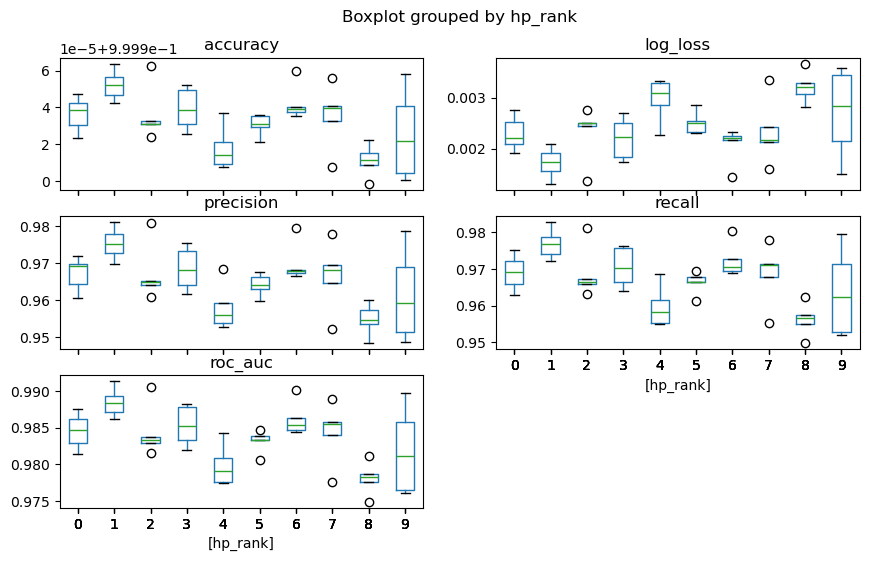

In [25]:
CollectedMetrics.drop('fold', axis=1).boxplot(
    by='hp_rank', 
    sharey=False, 
    grid=False, 
    layout = (3, 2), 
    figsize = (10, 6), 
    meanline=True
)